## Exploring different SynapseCLR features

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import cuml
from cuml import PCA, TSNE, UMAP

from synapse_utils import io, vis

import seaborn as sns
import colorcet as cc

import scipy.cluster.hierarchy as sch
from scipy.spatial import distance

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
repo_root = '../..'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

run_id = 'synapseclr__so3__seed_42__second_stage'

checkpoint_path = f'../../output/checkpoint__{run_id}'
contamination_indices_path = '../../tables/meta_df_contamination_indices.npy'
reload_epoch = 99
node_idx_list = [0, 1, 2, 3]

imputed_cell_types_df_path = os.path.join(
    checkpoint_path, 'analysis', 'gp', 'synapse_simclr_consensus', 'consensus__meta__uncensored.csv')
imputed_meta_ext_df_path = os.path.join(
    checkpoint_path, 'analysis', 'gp', 'synapse_simclr_production', 'imputed_meta__rbf__synapse_simclr__ensemble.csv')
cell_subtypes_df_path = '../../tables/annotated_synapse_cell_subtypes.csv'
clustering_labels_npy_path = '../../tables/meta_df_clustering_labels.npy'

In [3]:
cell_type_int_to_label_map = {
    0: 'ex',
    1: 'in'
}

# note: this is reversed from usual; DBSNP decided to order the clusters like this!
cluster_int_to_label_map = {
    0: 'in',
    1: 'ex'
}

## Feature clustering

In [4]:
# let's load projection middle features
load_prefix = 'projector.mlp.0'
save_prefix = load_prefix.replace('.', '_')
l2_normalize = False

features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook=load_prefix,
    dataset_path=dataset_path,
    l2_normalize=l2_normalize,
    contamination_indices_path=contamination_indices_path)

features_nf = features_nf.astype(np.float64)

In [5]:
res_nf = features_nf - np.mean(features_nf, axis=0)[None, :]
s_f = np.std(res_nf, axis=0)
z_score_nf = res_nf / s_f[None, :]
n = features_nf.shape[0]
cov_ff = res_nf.T @ res_nf / (n * s_f[None, :] * s_f[:, None])
cov_ff = 0.5 * (cov_ff + cov_ff.T)

corr_condensed = distance.squareform(1. - np.abs(cov_ff), checks=False)
linkage = sch.linkage(cov_ff, method='average', optimal_ordering=True)

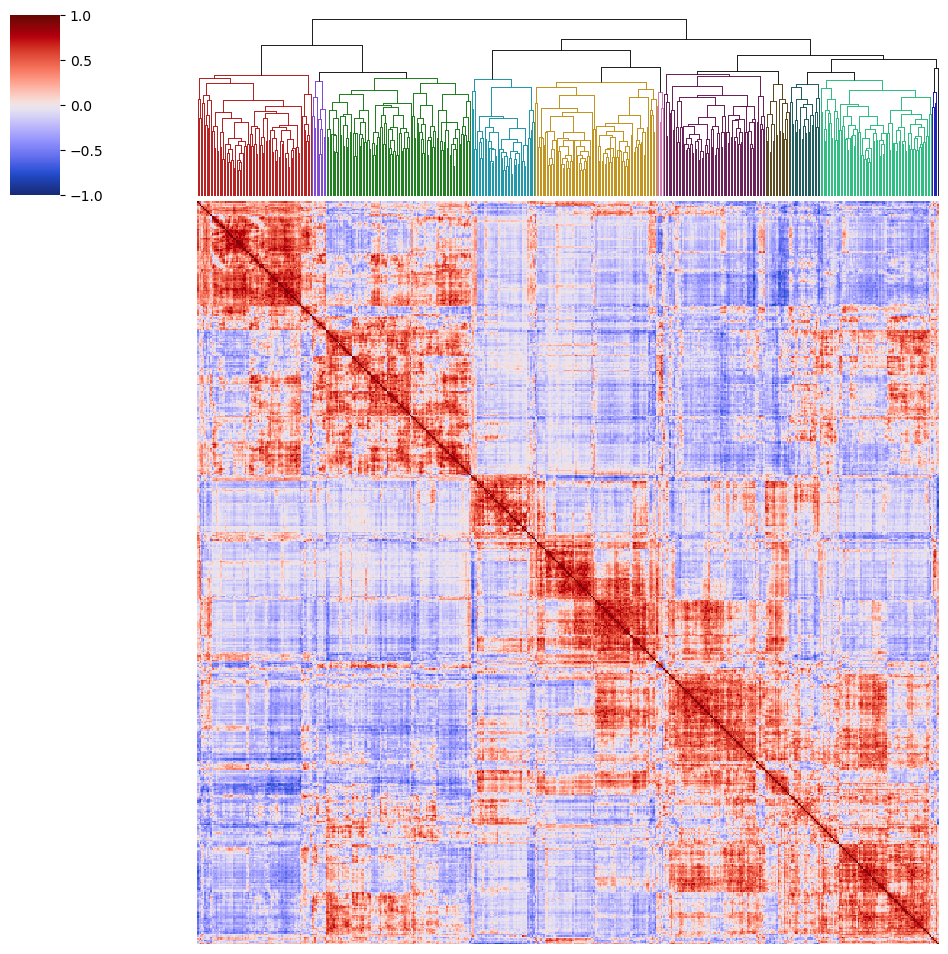

In [7]:
cg = sns.clustermap(
    cov_ff,
    row_linkage=linkage,
    col_linkage=linkage,
    cmap=cc.diverging_bwr_20_95_c54,
    vmin=-1,
    vmax=1)

cg.ax_row_dendrogram.set_visible(False);
cg.ax_heatmap.set_xticks([]);
cg.ax_heatmap.set_yticks([]);

sch.set_link_color_palette(cc.glasbey_dark)

with plt.rc_context({'lines.linewidth': 0.5}):
    dendro = sch.dendrogram(
        linkage,
        ax=cg.ax_col_dendrogram,
        above_threshold_color='k')

output_path = os.path.join(checkpoint_path, 'analysis', 'feature_clustering')
os.makedirs(output_path, exist_ok=True)
cg.savefig(os.path.join(output_path, f'feature_correlation__{save_prefix}.pdf'))

## PCA of different features

[W] [02:57:35.123651] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defauts to using min(n_samples, n_features) rather than 1
[W] [02:57:35.854041] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defauts to using min(n_samples, n_features) rather than 1
[W] [02:57:36.434863] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defauts to using min(n_samples, n_features) rather than 1


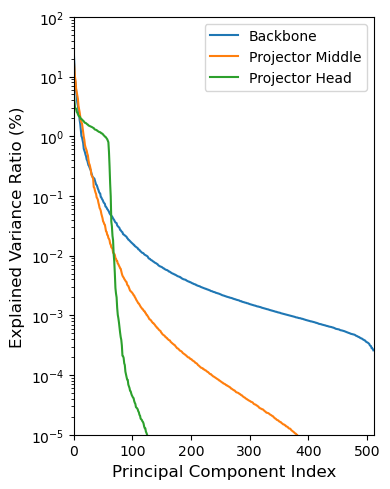

In [28]:
load_prefix_list = [
    'encoder.fc',
    'projector.mlp.0',
    'projector.mlp.3']

l2_normalize_list = [
    False,
    False,
    True]

label_list = [
    'Backbone',
    'Projector Middle',
    'Projector Head']

fig, ax = plt.subplots(figsize=(4, 5))

for load_prefix, l2_normalize, label in zip(load_prefix_list, l2_normalize_list, label_list):

    save_prefix = load_prefix.replace('.', '_')

    features_nf, meta_df, meta_ext_df = io.load_features(
        checkpoint_path,
        node_idx_list,
        reload_epoch,
        feature_hook=load_prefix,
        dataset_path=dataset_path,
        l2_normalize=l2_normalize,
        contamination_indices_path=contamination_indices_path)

    features_nf = features_nf.astype(np.float64)
    feature_pca = PCA().fit(features_nf)
    
    ax.plot(100 * feature_pca.explained_variance_ratio_, label=label)

ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Principal Component Index')
ax.set_ylabel('Explained Variance Ratio (%)')
ax.set_ylim((1e-5, 1e2))
ax.set_xlim((0, 512))

fig.tight_layout()

output_path = os.path.join(checkpoint_path, 'analysis', 'feature_clustering')
os.makedirs(output_path, exist_ok=True)
fig.savefig(os.path.join(output_path, 'pca__explained_variance__different_features.pdf'))

## Interpreting projector head features

In [29]:
load_prefix = 'projector.mlp.3'
save_prefix = load_prefix.replace('.', '_')
l2_normalize = True
reorder_method = 'pca'
n_pcs = 60
n_vis_features = 10

features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook=load_prefix,
    dataset_path=dataset_path,
    l2_normalize=l2_normalize,
    contamination_indices_path=contamination_indices_path)

features_nf = features_nf.astype(np.float64)

if reorder_method == 'pca':
    features_pca_np = PCA(n_components=n_pcs).fit_transform(features_nf)
    features_nf = features_pca_np
elif reorder_method == 'sort':
    sort_order = np.argsort(np.std(features_nf, axis=0))[::-1]
    features_nf = features_nf[:, sort_order]
else:
    raise ValueError

## Feature spectrum of stratified synapses

In [30]:
res_nf = features_nf - np.mean(features_nf, axis=0)[None, :]
s_f = np.std(res_nf, axis=0)
z_score_nf = res_nf / s_f[None, :]
n = features_nf.shape[0]
cov_ff = res_nf.T @ res_nf / (n * s_f[None, :] * s_f[:, None])
cov_ff = 0.5 * (cov_ff + cov_ff.T)

In [31]:
# helper
def get_row_indices_from_synapse_ids(synapse_ids, meta_df):
    synapse_id_to_meta_row_idx_map = {
        synapse_id: row_idx for row_idx, synapse_id in enumerate(meta_df['synapse_id'].values)}
    return [x for x in map(synapse_id_to_meta_row_idx_map.get, synapse_ids)
            if x is not None]

from synapse_utils.commons import load_imputed_annotations_stochastic

# which annotations to use?
annotations_to_use = 'imputed'
cell_type_strategy = 'consensus'

if annotations_to_use == 'manual':
    analysis_meta_ext_df = meta_ext_df.copy()

elif annotations_to_use == 'imputed':
    analysis_meta_ext_df = load_imputed_annotations_stochastic(
    meta_df,
    imputed_cell_types_df_path,
    imputed_meta_ext_df_path)

In [32]:
synapse_ids_for_cluster_map = dict()
labels_n = np.load(os.path.join(checkpoint_path, 'indices', f'clustering_labels_n.npy'))
for cluster_int, cluster_label in cluster_int_to_label_map.items():
    synapse_ids_for_cluster_map[cluster_label] = meta_df[labels_n == cluster_int]['synapse_id'].values

In [33]:
stratified_synapse_id_dict = dict()
stratified_synapse_id_dict['cluster_ex'] = synapse_ids_for_cluster_map['ex']
stratified_synapse_id_dict['cluster_in'] = synapse_ids_for_cluster_map['in']
stratified_synapse_id_dict['has_mito_pre'] = analysis_meta_ext_df[analysis_meta_ext_df['has_mito_pre'].values.astype(bool)].index.values
stratified_synapse_id_dict['has_mito_post'] = analysis_meta_ext_df[analysis_meta_ext_df['has_mito_post'].values.astype(bool)].index.values
stratified_synapse_id_dict['has_large_cleft'] = analysis_meta_ext_df[analysis_meta_ext_df['cleft_size_log1p_zscore'] > 0].index.values
stratified_synapse_id_dict['has_large_mito_pre'] = analysis_meta_ext_df[analysis_meta_ext_df['mito_size_pre_vx_log1p_zscore_zi'] > 0].index.values
stratified_synapse_id_dict['has_large_mito_post'] = analysis_meta_ext_df[analysis_meta_ext_df['mito_size_post_vx_log1p_zscore_zi'] > 0].index.values
stratified_synapse_id_dict['has_small_mito_pre'] = analysis_meta_ext_df[analysis_meta_ext_df['mito_size_pre_vx_log1p_zscore_zi'] < 0].index.values
stratified_synapse_id_dict['has_small_mito_post'] = analysis_meta_ext_df[analysis_meta_ext_df['mito_size_post_vx_log1p_zscore_zi'] < 0].index.values

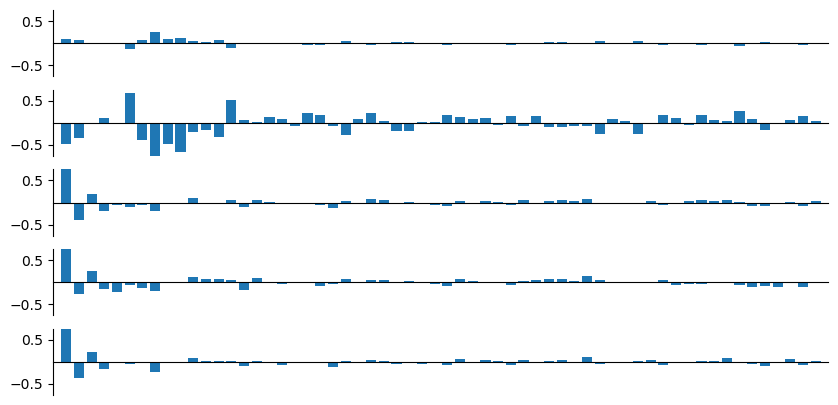

In [34]:
keys = [
    'cluster_ex',
    'cluster_in',
    'has_large_cleft',
    'has_large_mito_pre',
    'has_large_mito_post',
]

fig, axs = plt.subplots(nrows=len(keys), figsize=(10, 1 * len(keys)))

for n in range(len(keys)):
    key = keys[n]
    ax = axs[n]
    
    if isinstance(key, str):
        indices = get_row_indices_from_synapse_ids(stratified_synapse_id_dict[key], meta_df)
        mean_z_score_f = np.mean(z_score_nf[indices], 0)
    
    elif isinstance(key, tuple):
        pos_indices = get_row_indices_from_synapse_ids(stratified_synapse_id_dict[key[0]], meta_df)
        neg_indices = get_row_indices_from_synapse_ids(stratified_synapse_id_dict[key[1]], meta_df)
        mean_pos_z_score_f = np.mean(z_score_nf[pos_indices], 0)
        mean_neg_z_score_f = np.mean(z_score_nf[neg_indices], 0)
        mean_z_score_f = mean_pos_z_score_f - mean_neg_z_score_f

    ax.bar(
        np.arange(mean_z_score_f.shape[0]),
        mean_z_score_f, antialiased=True)
    
    ax.set_xlim((-1, z_score_nf.shape[-1]))
    ax.set_ylim((-0.75, 0.75))
    ax.set_yticks([-0.5, +0.5])
    ax.set_xticks([])
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position('zero')

## Spearman correlation analysis

In [35]:
regression_keys = [
    'pre_synaptic_volume_log1p_zscore',
    'post_synaptic_volume_log1p_zscore',
    'cleft_size_log1p_zscore',
    'pre_cell_type',
    'post_cell_type',
    'has_mito_pre',
    'has_mito_post',
    'mito_size_pre_vx_log1p_zscore_zi',
    'mito_size_post_vx_log1p_zscore_zi',
    'presyn_soma_dist_log1p_zscore',
    'postsyn_soma_dist_log1p_zscore',
]

condition_keys = [
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    'has_mito_pre',
    'has_mito_post',
    None,
    None,
]

condition_types = [
    'continuous',
    'continuous',
    'continuous',
    'binary',
    'binary',
    'binary',
    'binary',
    'continuous',
    'continuous',
    'continuous',
    'continuous',
]

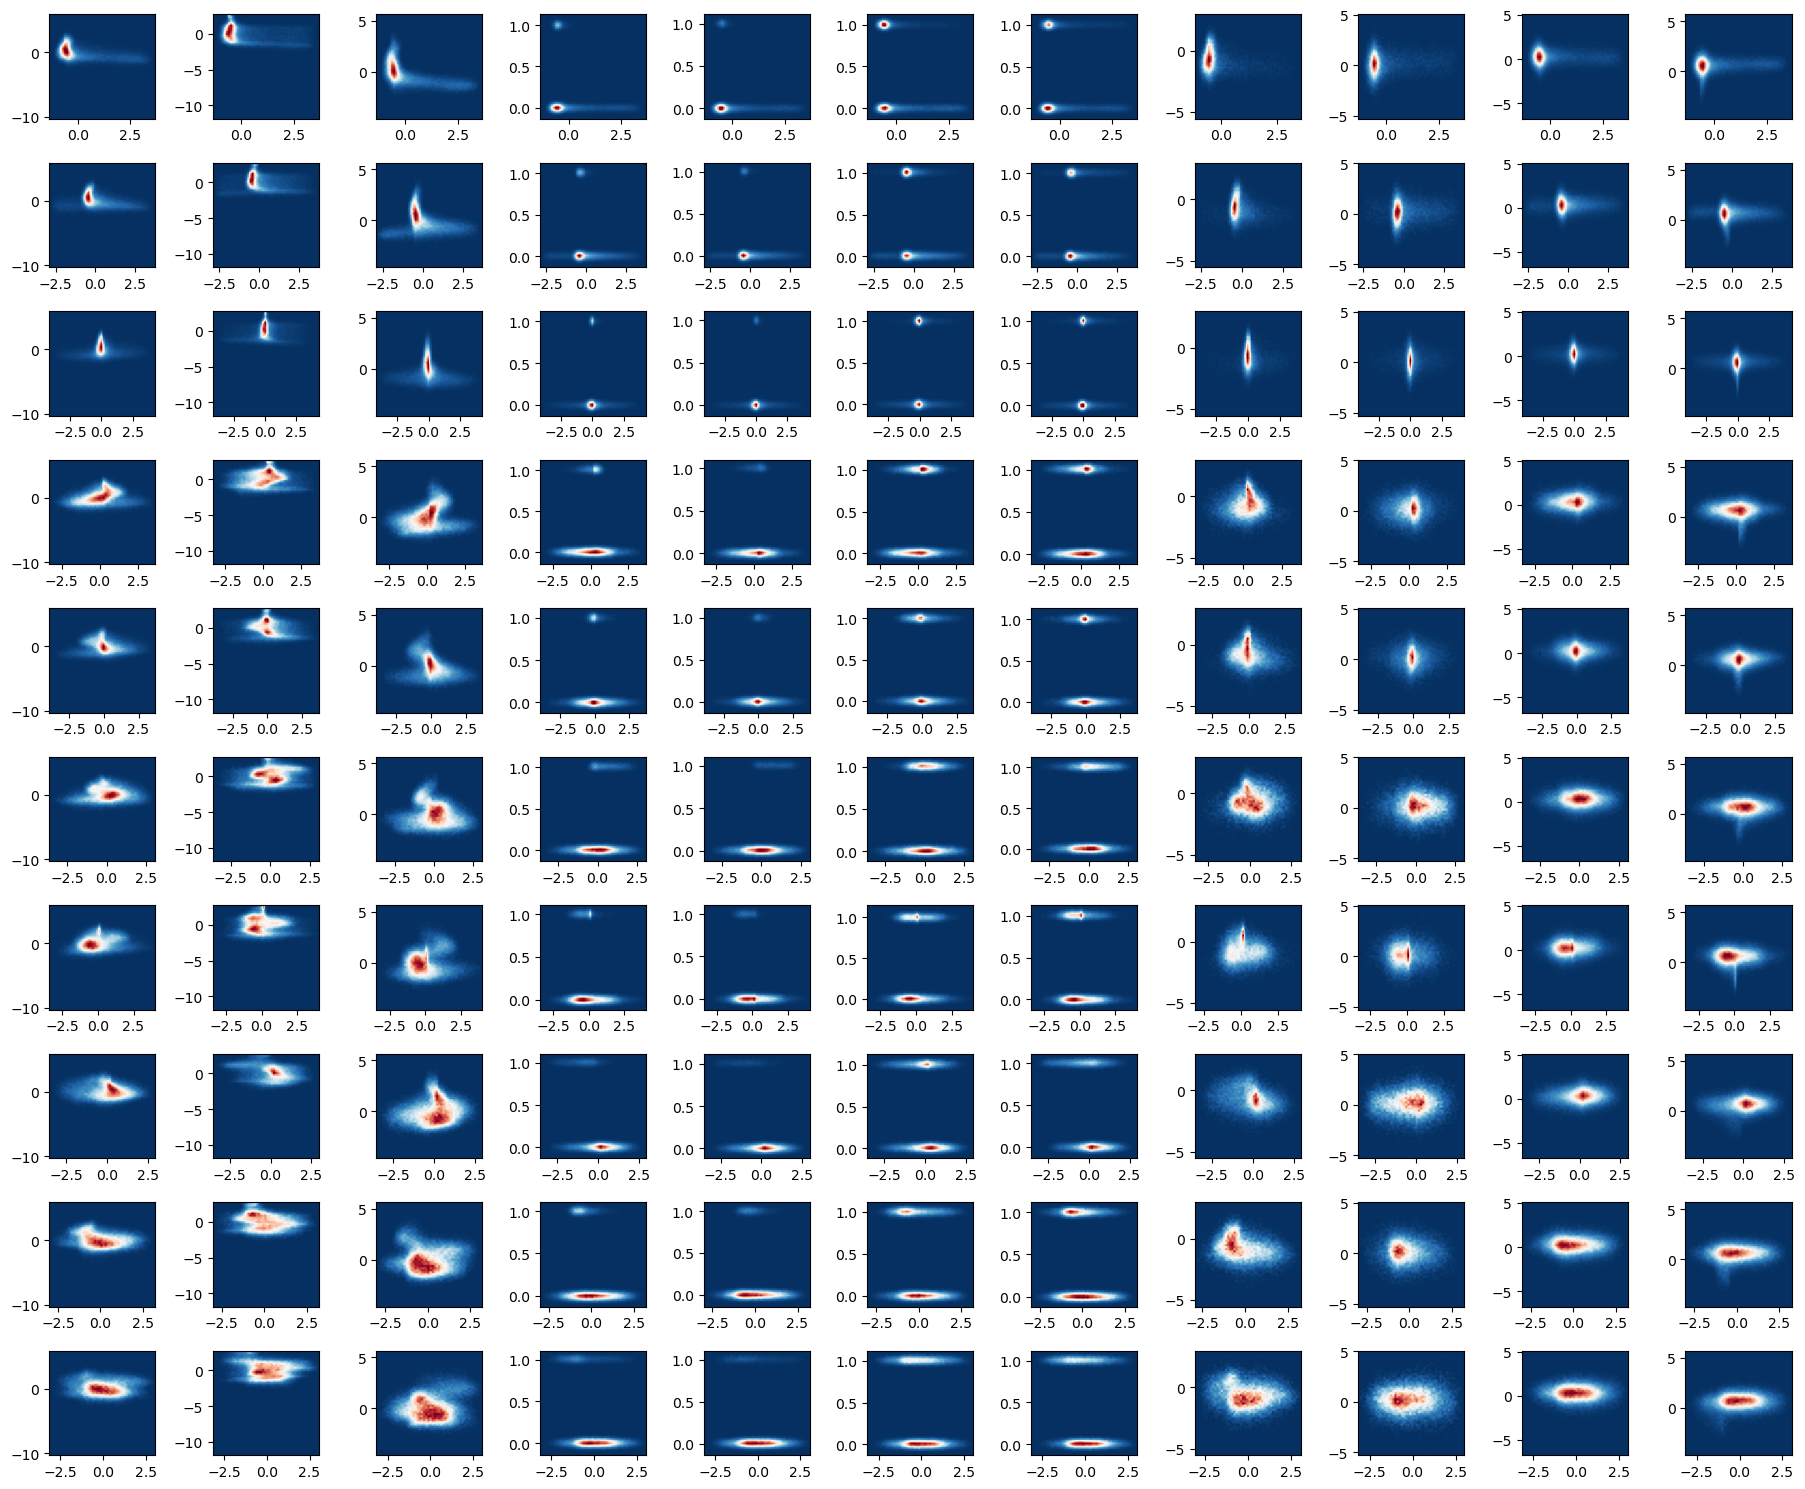

In [36]:
nrows = n_vis_features
ncols = len(regression_keys)
scale = 1.5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.1 * ncols * scale, nrows * scale))

# for ax in axs.flat:
#     ax.axis('square')

for i_feature in range(n_vis_features):
    for i_key in range(len(regression_keys)):

        ax = axs[i_feature, i_key]
        
        regression_key = regression_keys[i_key]
        condition_key = condition_keys[i_key]
        condition_type = condition_types[i_key]
        
        z_n = z_score_nf[:, i_feature].copy()
        response_n = analysis_meta_ext_df[regression_key].values.copy().astype(float)
        
        if condition_key is not None:
            mask = analysis_meta_ext_df[condition_key].values.astype(bool)
            z_n = z_n[mask]
            response_n = response_n[mask]
        
        if condition_type == 'binary':
            response_n += 0.03 * np.random.randn(response_n.shape[0])
            
        heatmap, xedges, yedges = np.histogram2d(z_n, response_n, bins=50)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=plt.cm.RdBu_r)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.set_xlim((xedges[0], xedges[-1]))
        ax.set_ylim(((yedges[0], yedges[-1])))
        ax.set_aspect('auto')
            
fig.tight_layout()

output_path = os.path.join(checkpoint_path, 'analysis', 'feature_clustering')
os.makedirs(output_path, exist_ok=True)
fig.savefig(os.path.join(output_path, 'projector_feature_vs_anonotations.pdf'))

In [37]:
from scipy.stats import spearmanr

spearman_corr_rf = np.zeros((len(regression_keys), z_score_nf.shape[-1]))
spearman_pval_rf = np.zeros((len(regression_keys), z_score_nf.shape[-1]))
for r, (regression_key, condition_key) in enumerate(zip(regression_keys, condition_keys)):
    print(f'{regression_key} ...')
    for f in range(z_score_nf.shape[-1]):
        z_n = z_score_nf[:, f]
        response_n = analysis_meta_ext_df[regression_key].values
        if condition_key is not None:
            mask = analysis_meta_ext_df[condition_key].values.astype(bool)
            z_n = z_n[mask]
            response_n = response_n[mask]
        s = spearmanr(z_n, response_n)
        spearman_corr_rf[r, f] = s.correlation
        spearman_pval_rf[r, f] = s.pvalue

pre_synaptic_volume_log1p_zscore ...
post_synaptic_volume_log1p_zscore ...
cleft_size_log1p_zscore ...
pre_cell_type ...
post_cell_type ...
has_mito_pre ...
has_mito_post ...
mito_size_pre_vx_log1p_zscore_zi ...
mito_size_post_vx_log1p_zscore_zi ...
presyn_soma_dist_log1p_zscore ...
postsyn_soma_dist_log1p_zscore ...


In [39]:
from statsmodels.stats.multitest import multipletests

spearman_pval_adj_rf = np.zeros((len(regression_keys), z_score_nf.shape[-1]))

for r in range(len(regression_keys)):
    _, pvals_adj, _, _ = multipletests(spearman_pval_rf[r, :], alpha=0.01, method='bonferroni')
    spearman_pval_adj_rf[r, :] = pvals_adj

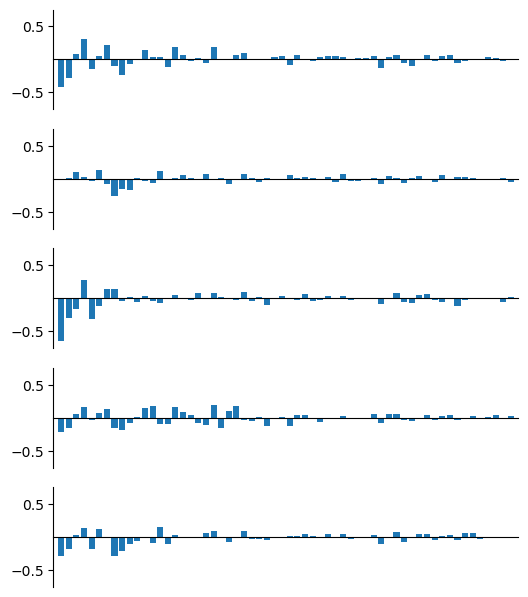

In [40]:
plot_regression_keys = {
    'pre_synaptic_volume_log1p_zscore',
    'post_synaptic_volume_log1p_zscore',
    'cleft_size_log1p_zscore',
    'has_mito_pre',
    'has_mito_post',
}

fig, axs = plt.subplots(nrows=len(plot_regression_keys), figsize=(6, 1.5 * len(plot_regression_keys)))

for i, key in enumerate(plot_regression_keys):
    
    r = regression_keys.index(key)
    ax = axs[i]
    
    ax.bar(
        np.arange(z_score_nf.shape[-1]),
        spearman_corr_rf[r],
        antialiased=True)

    ax.set_xlim((-1, z_score_nf.shape[-1]))
    ax.set_ylim((-0.75, 0.75))
    ax.set_yticks([-0.5, +0.5])
    ax.set_xticks([])
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position('zero')

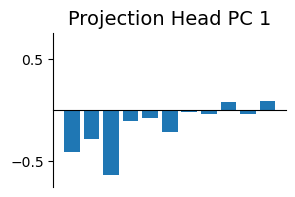

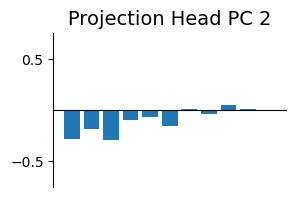

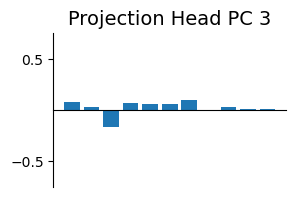

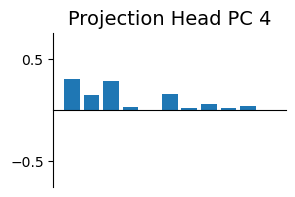

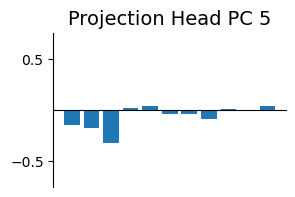

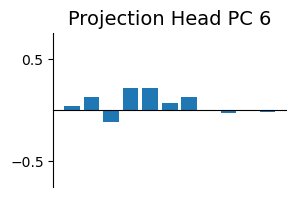

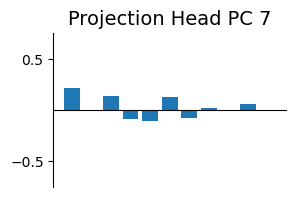

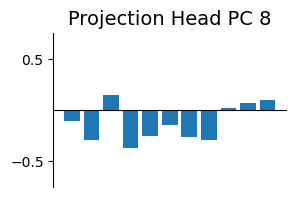

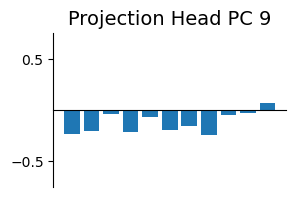

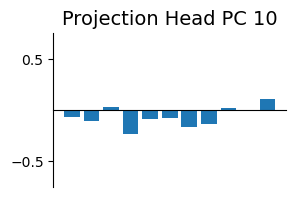

In [41]:
for feature_idx in range(n_vis_features):

    fig, ax = plt.subplots(figsize=(3, 2))

    ax.bar(
        np.arange(spearman_corr_rf.shape[0]),
        spearman_corr_rf[:, feature_idx])

    ax.set_ylim((-0.75, 0.75))
    ax.set_yticks([-0.5, +0.5])
    ax.set_xticks([])
    # ax.set_xticks(np.arange(spearman_corr_rf.shape[0]));
    # ax.set_xticklabels([""] * spearman_corr_rf.shape[0]);

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position('zero')

    ax.set_title(f'Projection Head PC {feature_idx + 1}', fontsize=14)
    output_path = os.path.join(checkpoint_path, 'analysis', 'feature_clustering')
    os.makedirs(output_path, exist_ok=True)
    fig.savefig(os.path.join(output_path, f'feature_spearman_to_labels__{feature_idx + 1}.pdf'))

## Generate Samples

In [43]:
ctx = vis.SynapseVisContext(
    dataset_path,
    '../../configs/config__ext/augmenter_display.yaml',
    meta_df_override=meta_df,
    device='cuda')

In [46]:
n_sample_synapse_per_feature = 5

output_path = os.path.join(checkpoint_path, 'analysis', 'feature_clustering', 'samples')
os.makedirs(output_path, exist_ok=True)
    
for feature_idx in range(n_vis_features):

    sorted_by_feature_n = np.argsort(features_nf[:, feature_idx])

    mid = len(sorted_by_feature_n) // 2
    quarter = len(sorted_by_feature_n) // 4
    
    for i in range(n_sample_synapse_per_feature):
        
        output_file_path = os.path.join(output_path, f'synapse__feature_idx_{feature_idx}__low_{i}__view_1.png')
        print(output_file_path + ' ...')
        if not os.path.exists(output_file_path):
            fig = vis.make_3d_synapse_figure(ctx, sorted_by_feature_n[mid - quarter - i], surface_point_cloud_opacity=0.06, view_plane=1);
            fig.write_image(output_file_path)
        else:
            print('[skipped]')
            
        output_file_path = os.path.join(output_path, f'synapse__feature_idx_{feature_idx}__low_{i}__view_2.png')
        print(output_file_path + ' ...')
        if not os.path.exists(output_file_path):
            fig = vis.make_3d_synapse_figure(ctx, sorted_by_feature_n[mid - quarter - i], surface_point_cloud_opacity=0.06, view_plane=2, fig=fig);
            fig.write_image(output_file_path)
        else:
            print('[skipped]')

    for i in range(n_sample_synapse_per_feature):
        
        output_file_path = os.path.join(output_path, f'synapse__feature_idx_{feature_idx}__high_{i}__view_1.png')
        print(output_file_path + ' ...')
        if not os.path.exists(output_file_path):
            fig = vis.make_3d_synapse_figure(ctx, sorted_by_feature_n[mid + quarter + i], surface_point_cloud_opacity=0.06, view_plane=1);
            fig.write_image(output_file_path)
        else:
            print('[skipped]')
            
        output_file_path = os.path.join(output_path, f'synapse__feature_idx_{feature_idx}__high_{i}__view_2.png')
        print(output_file_path + ' ...')
        if not os.path.exists(output_file_path):
            fig = vis.make_3d_synapse_figure(ctx, sorted_by_feature_n[mid + quarter + i], surface_point_cloud_opacity=0.06, view_plane=2, fig=fig);
            fig.write_image(output_file_path)
        else:
            print('[skipped]')

../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/feature_clustering/samples/synapse__feature_idx_0__low_0__view_1.png ...
[skipped]
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/feature_clustering/samples/synapse__feature_idx_0__low_0__view_2.png ...
[skipped]
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/feature_clustering/samples/synapse__feature_idx_0__low_1__view_1.png ...
[skipped]
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/feature_clustering/samples/synapse__feature_idx_0__low_1__view_2.png ...
[skipped]
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/feature_clustering/samples/synapse__feature_idx_0__low_2__view_1.png ...
[skipped]
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/feature_clustering/samples/synapse__feature_idx_0__low_2__view_2.png ...
[skipped]
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/

## Assemble Samples into a Single Plot

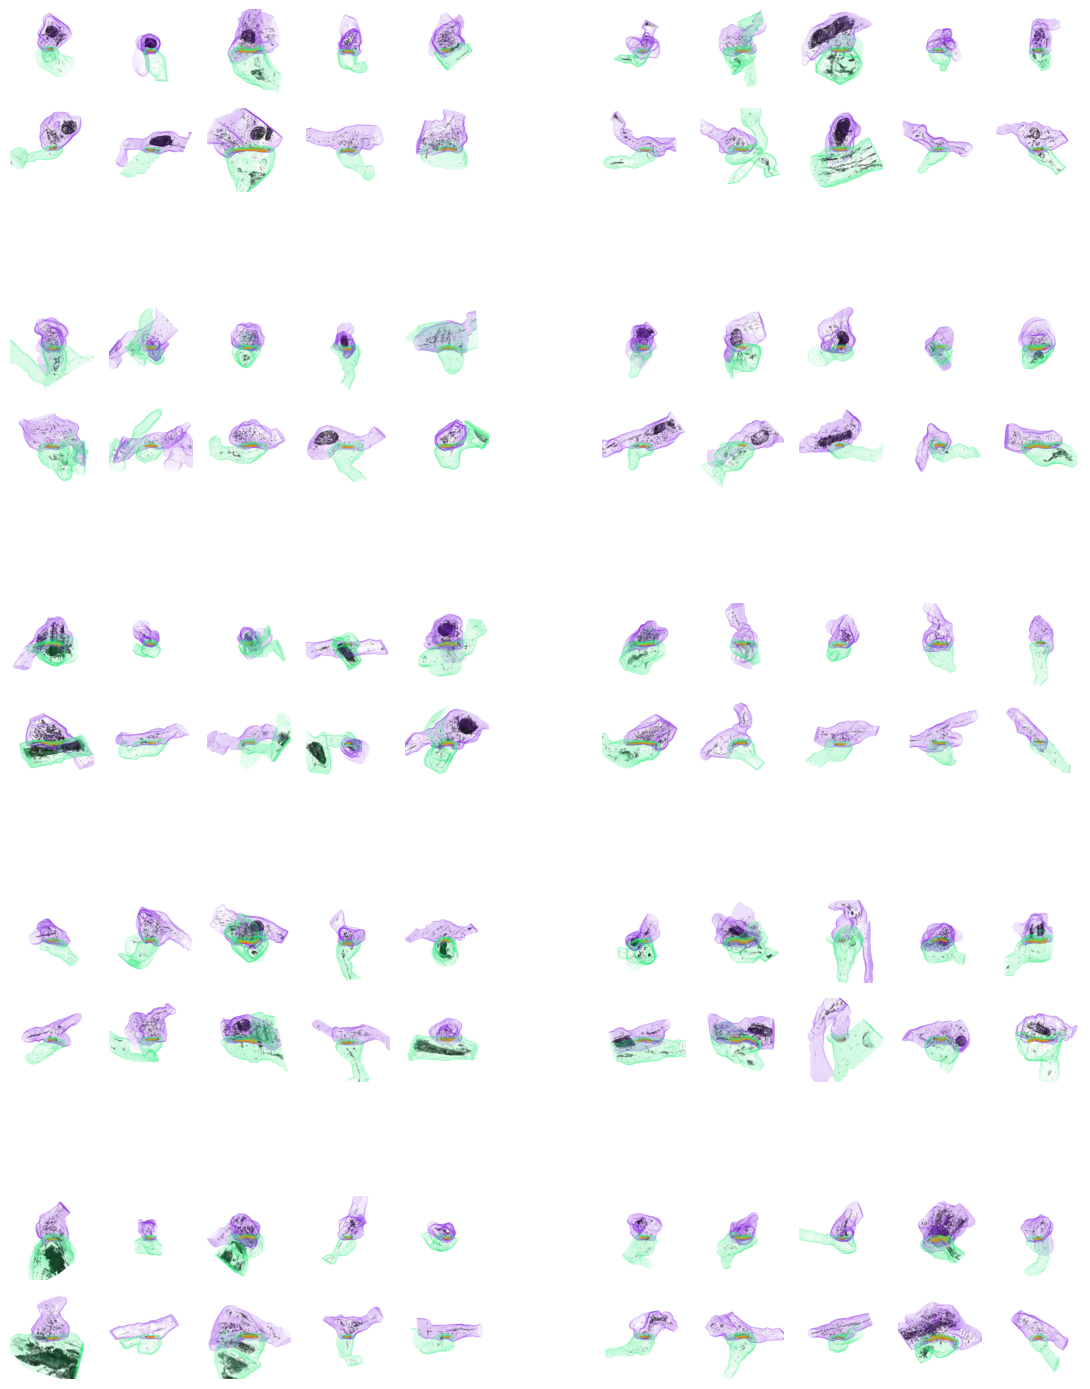

In [47]:
import matplotlib.image as img

feature_offset = 5
n_vis_features = 5
n_sample_synapse_per_feature = 5

nrows = 3 * n_vis_features - 1
ncols = 2 * n_sample_synapse_per_feature + 1
scale = 1.

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(scale * ncols, scale * nrows))

samples_output_path = os.path.join(checkpoint_path, 'analysis', 'feature_clustering', 'samples')

for ax in axs.flat:
    ax.axis('off')
    
for feature_idx in range(n_vis_features):

    for i in range(n_sample_synapse_per_feature):
        
        ax = axs[3 * feature_idx, i]
        image = img.imread(os.path.join(samples_output_path, f'synapse__feature_idx_{feature_offset + feature_idx}__low_{i}__view_1.png'))
        ax.imshow(image)

        ax = axs[3 * feature_idx + 1, i]
        image = img.imread(os.path.join(samples_output_path, f'synapse__feature_idx_{feature_offset + feature_idx}__low_{i}__view_2.png'))
        ax.imshow(image)
        
    for i in range(n_sample_synapse_per_feature):
        
        ax = axs[3 * feature_idx, i + n_sample_synapse_per_feature + 1]
        image = img.imread(os.path.join(samples_output_path, f'synapse__feature_idx_{feature_offset + feature_idx}__high_{i}__view_1.png'))
        ax.imshow(image)
        
        ax = axs[3 * feature_idx + 1, i + n_sample_synapse_per_feature + 1]
        image = img.imread(os.path.join(samples_output_path, f'synapse__feature_idx_{feature_offset + feature_idx}__high_{i}__view_2.png'))
        ax.imshow(image)
        
fig.tight_layout()

output_path = os.path.join(checkpoint_path, 'analysis', 'feature_clustering')
fig.savefig(os.path.join(output_path, f'projector_feature_samples__{feature_offset + 1}_to_{feature_offset + n_vis_features}.pdf'), dpi=200)